# Sampling Bayesian Inference for the parameters of a line fit

## 1 Import all the things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [18]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis, utils

## 2 Make the data

In [7]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b, sigma = thetas
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    ε = rs.normal(loc=0, scale=sigma, size = len(x)) 
    return m * x + b + ε

In [8]:
length_df = 1000
xs = np.zeros((length_df, 3))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    sigma = abs(rs.normal(loc=0, scale=10))
    thetas = [m, b, sigma]
    xs[r,:] = thetas
    ys.append(simulator(thetas))

## 3 Define the model

In [5]:
def linefit_model(xs,
                  exponential,
                  y=None):
    m = numpyro.sample("m", dist.TruncatedNormal(5, 2, low = 0.01))
    b = numpyro.sample("b", dist.Normal(0, 5))
    σ = numpyro.sample("σ", dist.Exponential(exponential))
    modelx = m * xs + b 
    pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=y)

def hierarchical_model(planet_code,
                       pendulum_code,
                       times,
                       exponential,
                       pos_obs=None):
    μ_a_g = numpyro.sample("μ_a_g", dist.TruncatedNormal(12.5, 5, low=0.01))
    # scale parameters should be log uniform so that they don't go negative 
    # and so that they're not uniform
    # 1 / x in linear space
    σ_a_g = numpyro.sample("σ_a_g", dist.TruncatedNormal(0.1, 0.01, low=0.01))
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    ## plates are a numpyro primitive or context manager for handing conditionally independence
    ## for instance, we wish to model a_g for each planet independently
    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g,
                                                         low=0.01))
        # helps because a_gs are being pulled from same normal dist
        # removes dependency of a_g on sigma_a_g on a prior level
        # removing one covariance from model, model is easier
        # to sample from
    
    ## we also wish to model L and theta for each pendulum independently
    ## here we draw from an uniform distribution
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.TruncatedNormal(5, 2, low=0.01))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100,
                                                             jnp.pi/500,
                                                             low=0.00001))

    ## σ is the error on the position measurement for each moment in time
    ## we also model this
    ## eventually, we should also model the error on each parameter independently?
    ## draw from an exponential distribution parameterized by a rate parameter
    ## the mean of an exponential distribution is 1/r where r is the rate parameter
    ## exponential distributions are never negative. This is good for error.
    σ = numpyro.sample("σ", dist.Exponential(exponential))
    
    ## the moments in time are not independent, so we do not place the following in a plate
    ## instead, the brackets segment the model by pendulum and by planet,
    ## telling us how to conduct the inference
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code]) * times))
    ## don't forget to use jnp instead of np so jax knows what to do
    ## A BIG QUESTION I STILL HAVE IS WHAT IS THE LIKELIHOOD? IS IT JUST SAMPLED FROM?
    ## again, for each pendulum we compare the observed to the modeled position:
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)


def unpooled_model(planet_code,
                   pendulum_code,
                   times,
                   exponential,
                   pos_obs=None):
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))
    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(12.5, 5,
                                                         low=0, high=25))
    with numpyro.plate("pend_i", n_pendulums):
        L = numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0.01))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100,
                                                             jnp.pi/500,
                                                             low=0.00001))
    σ = numpyro.sample("σ", dist.Exponential(exponential))
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] *
                         jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code]) * times))
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)


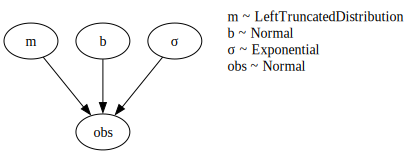

In [10]:
exponential = 100
numpyro.render_model(
    model=linefit_model,
    model_args=(xs,exponential),
    render_distributions=True,
    render_params=True,
)

## 4 Do the sampling
To do this first make some true values.

In [26]:
true_thetas = [1, 0, 2]
xs = np.linspace(0, 100, 101)
ys = simulator(true_thetas)

In [27]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(linefit_model, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=100, num_chains = 4)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, xs,
                exponential, y = ys)

posterior_samples = mcmc.get_samples()

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

In [28]:
table, inf_data = utils.sampling_summary_table(mcmc)
table

divergences: 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,-0.130,0.323,-0.614,0.293,0.012,0.011,1648.0,1377.0,1.0
m,0.996,0.005,0.988,1.004,0.000,0.000,1974.0,1897.0,1.0
σ,1.193,0.055,1.098,1.289,0.001,0.001,9495.0,4218.0,1.0


<Figure size 640x480 with 0 Axes>

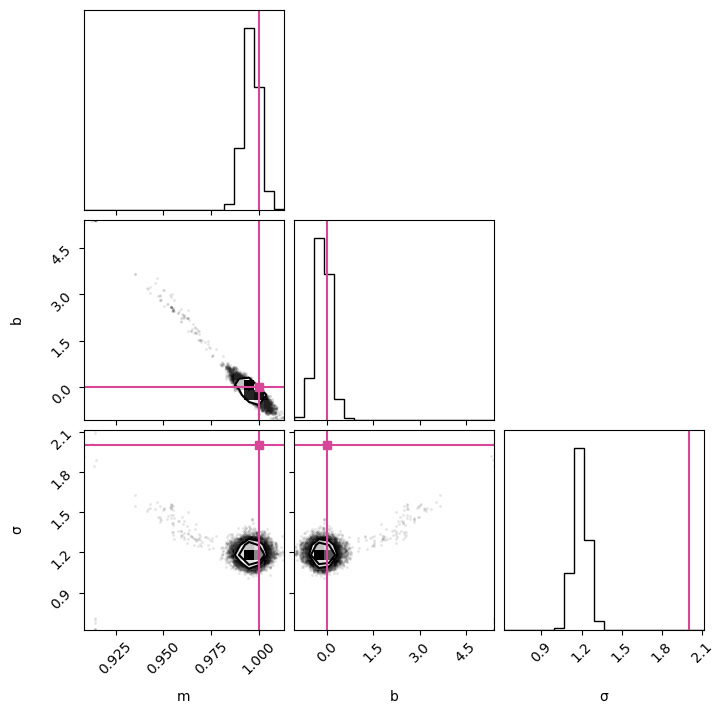

In [29]:
# take a look at the posterior
data = az.from_dict(
    posterior={"m": posterior_samples["m"][:], "b": posterior_samples["b"][:],
               "σ": posterior_samples["σ"][:]},
#     sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)
plt.clf()
figure = corner.corner(data, divergences=True, truths = true_thetas, truth_color = '#D84797')#,
                       #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])
plt.show()